In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm


In [17]:
path = "./Datasets"

transform = transforms.ToTensor()

dataset = datasets.MNIST(root=path, train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root=path, train=False, download=True, transform=transform)


In [18]:
class Basic_Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 256),
            nn.ReLU(),
            nn.Linear(256, 32)
        )

        self.decoder = nn.Sequential(
            nn.Linear(32, 256),
            nn.ReLU(),
            nn.Linear(256, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        out = self.decoder(z)
        return out.view(-1, 1, 28, 28)

In [19]:
class Deep_Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 32)
        )

        self.decoder = nn.Sequential(
            nn.Linear(32, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        out = self.decoder(z)
        return out.view(-1, 1, 28, 28)

In [20]:
def train_autoencoder(model,
                      train_loader,
                      val_loader,
                      criterion,
                      optimizer,
                      device=None,
                      num_epochs=50
                      ):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    train_losses = []
    val_losses = []
    train_errors = []
    val_errors = []

    for epoch in tqdm(range(num_epochs), desc="Epochs"):
        # TRAIN
        model.train()
        running_loss = 0.0
        running_error = 0.0
        n_samples = 0

        for x, _ in train_loader:
            x = x.to(device)
            batch_size = x.size(0)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, x)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * batch_size
            # MAE error for the batch
            batch_error = torch.mean(torch.abs(out - x)).item()
            running_error += batch_error * batch_size
            n_samples += batch_size

        epoch_train_loss = running_loss / n_samples
        epoch_train_error = running_error / n_samples
        train_losses.append(epoch_train_loss)
        train_errors.append(epoch_train_error)

        # VALIDATION
        model.eval()
        val_running_loss = 0.0
        val_running_error = 0.0
        val_n = 0
        with torch.no_grad():
            for x, _ in val_loader:
                x = x.to(device)
                batch_size = x.size(0)
                out = model(x)
                loss = criterion(out, x)
                val_running_loss += loss.item() * batch_size
                batch_error = torch.mean(torch.abs(out - x)).item()
                val_running_error += batch_error * batch_size
                val_n += batch_size

        epoch_val_loss = val_running_loss / val_n
        epoch_val_error = val_running_error / val_n
        val_losses.append(epoch_val_loss)
        val_errors.append(epoch_val_error)

        tqdm.write(
            f"Epoch {len(train_losses)}/{num_epochs} | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f} | Train MAE: {epoch_train_error:.4f} | Val MAE: {epoch_val_error:.4f}")

    metrics = {
        "train_loss": train_losses,
        "val_loss": val_losses,
        "train_error": train_errors,
        "val_error": val_errors
    }

    torch.save(model.state_dict(), f"{model.__class__.__name__}_ep{num_epochs}.pth")
    torch.save(metrics, f"{model.__class__.__name__}_ep{num_epochs}_metrics.pth")

    return metrics

In [21]:
def plot_metrics(metrics, figsize=(10, 4)):
    epochs = range(1, len(metrics["train_loss"]) + 1)

    plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1)
    plt.plot(epochs, metrics["train_loss"], label="train")
    plt.plot(epochs, metrics["val_loss"], label="val")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title("Loss curve")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, metrics["train_error"], label="train")
    plt.plot(epochs, metrics["val_error"], label="val")
    plt.xlabel("Epoch")
    plt.ylabel("MAE")
    plt.title("Reconstruction MAE")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [36]:
def test_autoencoder(models,
                     test_loader,
                     criterion,
                     model_names=None,
                     show_examples=8,
                     device=None,
                     figsize=None):

    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    device = torch.device(device)

    # Handle single model case - convert to list
    if not isinstance(models, list):
        models = [models]

    # Process models list to handle tuples or single models
    processed_models = []
    extracted_names = []

    for item in models:
        if isinstance(item, tuple):
            if len(item) == 3:
                # (model, load_path, name)
                model, load_path, name = item
                extracted_names.append(name)
            elif len(item) == 2:
                # (model, load_path)
                model, load_path = item
                extracted_names.append(None)
            else:
                raise ValueError(f"Invalid tuple format: {item}")
        else:
            # Just a model
            model, load_path = item, None
            extracted_names.append(None)
        processed_models.append((model, load_path))

    num_models = len(processed_models)

    # Generate model names: use provided model_names, then extracted names, then defaults
    if model_names is None:
        model_names = []
        for i, name in enumerate(extracted_names):
            if name is not None:
                model_names.append(name)
            else:
                model_names.append(f"Model {i+1}")

    # Ensure we have the right number of names
    if len(model_names) < num_models:
        model_names.extend([f"Model {i+1}" for i in range(len(model_names), num_models)])

    # Load models and compute metrics
    all_metrics = {}
    all_outputs = []
    test_images = None

    for idx, (model, load_path) in enumerate(processed_models):
        model.to(device)

        if load_path is not None:
            state = torch.load(load_path, map_location=device)
            model.load_state_dict(state)

        model.eval()
        total_loss = 0.0
        total_mae = 0.0
        n_samples = 0
        first_batch_outputs = None

        with torch.no_grad():
            for x, _ in test_loader:
                x = x.to(device)
                batch_size = x.size(0)
                out = model(x)
                loss = criterion(out, x)
                mae = torch.mean(torch.abs(out - x))

                total_loss += loss.item() * batch_size
                total_mae += mae.item() * batch_size
                n_samples += batch_size

                if show_examples and first_batch_outputs is None:
                    first_batch_outputs = out.detach().cpu()
                    if test_images is None:
                        test_images = x.detach().cpu()

        avg_loss = total_loss / n_samples if n_samples else 0.0
        avg_mae = total_mae / n_samples if n_samples else 0.0

        all_metrics[model_names[idx]] = {
            "test_loss": avg_loss,
            "test_mae": avg_mae
        }
        all_outputs.append(first_batch_outputs)

        print(f"{model_names[idx]} - Test Loss: {avg_loss:.4f}, Test MAE: {avg_mae:.4f}")

    # Display examples in grid: rows = test cases, columns = original + models
    if show_examples and test_images is not None:
        examples = min(show_examples, test_images.size(0))
        num_cols = num_models + 1  # +1 for original

        if figsize is None:
            figsize = (num_cols * 2, examples * 2)

        fig, axes = plt.subplots(examples, num_cols, figsize=figsize)

        # Handle single row case
        if examples == 1:
            axes = axes.reshape(1, -1)

        for row in range(examples):
            # First column: original image
            axes[row, 0].imshow(test_images[row].squeeze(), cmap="gray")
            axes[row, 0].axis("off")
            if row == 0:
                axes[row, 0].set_title("Original", fontsize=10, fontweight='bold')

            # Remaining columns: model outputs
            for col in range(num_models):
                axes[row, col + 1].imshow(all_outputs[col][row].squeeze(), cmap="gray")
                axes[row, col + 1].axis("off")
                if row == 0:
                    axes[row, col + 1].set_title(model_names[col], fontsize=10, fontweight='bold')

        plt.tight_layout()
        plt.show()

    return all_metrics

Using device: cuda


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50 | Train Loss: 0.0597 | Val Loss: 0.0337 | Train MAE: 0.1279 | Val MAE: 0.0811
Epoch 2/50 | Train Loss: 0.0273 | Val Loss: 0.0233 | Train MAE: 0.0698 | Val MAE: 0.0615
Epoch 3/50 | Train Loss: 0.0204 | Val Loss: 0.0180 | Train MAE: 0.0559 | Val MAE: 0.0510
Epoch 4/50 | Train Loss: 0.0163 | Val Loss: 0.0152 | Train MAE: 0.0474 | Val MAE: 0.0449
Epoch 5/50 | Train Loss: 0.0141 | Val Loss: 0.0134 | Train MAE: 0.0426 | Val MAE: 0.0411
Epoch 6/50 | Train Loss: 0.0126 | Val Loss: 0.0121 | Train MAE: 0.0393 | Val MAE: 0.0381
Epoch 7/50 | Train Loss: 0.0113 | Val Loss: 0.0110 | Train MAE: 0.0365 | Val MAE: 0.0359
Epoch 8/50 | Train Loss: 0.0103 | Val Loss: 0.0101 | Train MAE: 0.0342 | Val MAE: 0.0337
Epoch 9/50 | Train Loss: 0.0095 | Val Loss: 0.0095 | Train MAE: 0.0326 | Val MAE: 0.0325
Epoch 10/50 | Train Loss: 0.0089 | Val Loss: 0.0088 | Train MAE: 0.0311 | Val MAE: 0.0311
Epoch 11/50 | Train Loss: 0.0084 | Val Loss: 0.0085 | Train MAE: 0.0300 | Val MAE: 0.0301
Epoch 12/50 | Train

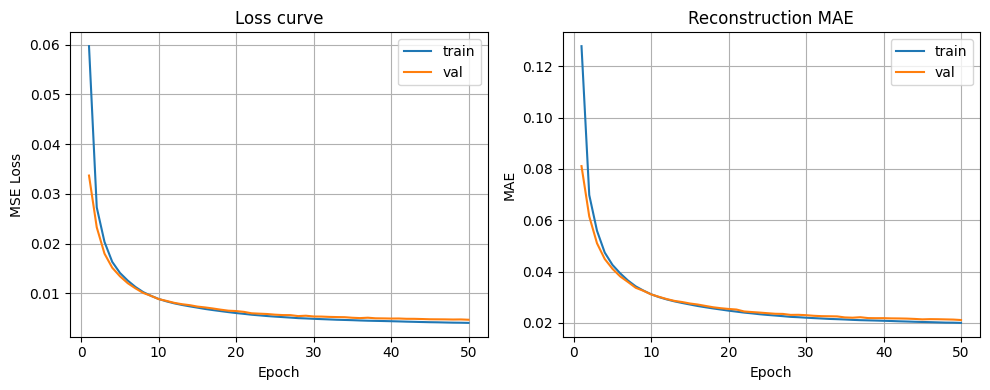

In [22]:
# Training the autoencoder

batch_size = 256
train_len = int(len(dataset) * 0.9)
val_len = len(dataset) - train_len

train_dataset, val_dataset = random_split(dataset, [train_len, val_len])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = Deep_Autoencoder()
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 50

# metrics = train_autoencoder(
#     model,
#     train_loader,
#     val_loader,
#     criterion,
#     optimizer,
#     device=device,
#     num_epochs=num_epochs,
# )

# plot_metrics(metrics)

Basic AE - Test Loss: 0.0048, Test MAE: 0.0215
Deep AE - Test Loss: 0.0045, Test MAE: 0.0206


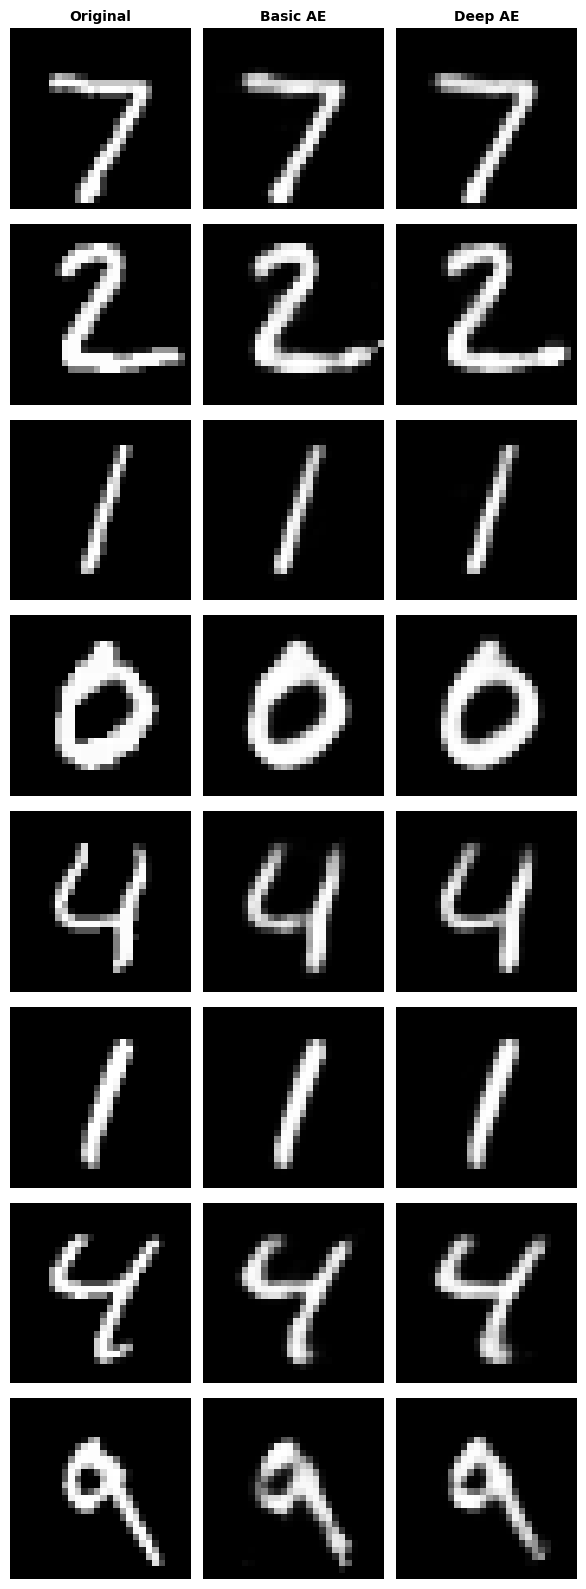

In [38]:
# Testing the autoencoder

# Load models from saved .pth files
basic_model = Basic_Autoencoder()
deep_model = Deep_Autoencoder()

# Create list of (model, path, name) tuples
models_to_test = [
    (basic_model, "basic_autoencoder.pth", "Basic AE"),
    (deep_model, "Deep_Autoencoder_ep50.pth", "Deep AE"),
]

test_criterion = nn.MSELoss()
test_metrics = test_autoencoder(
    models_to_test,
    test_loader,
    test_criterion,
    show_examples=8,
    device=device
)
